In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

Saving 1_Average_strain_top_Twist2_nRMSE.xlsx to 1_Average_strain_top_Twist2_nRMSE.xlsx


In [ ]:
# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
np.shape(X_scaled)

(3436, 26)

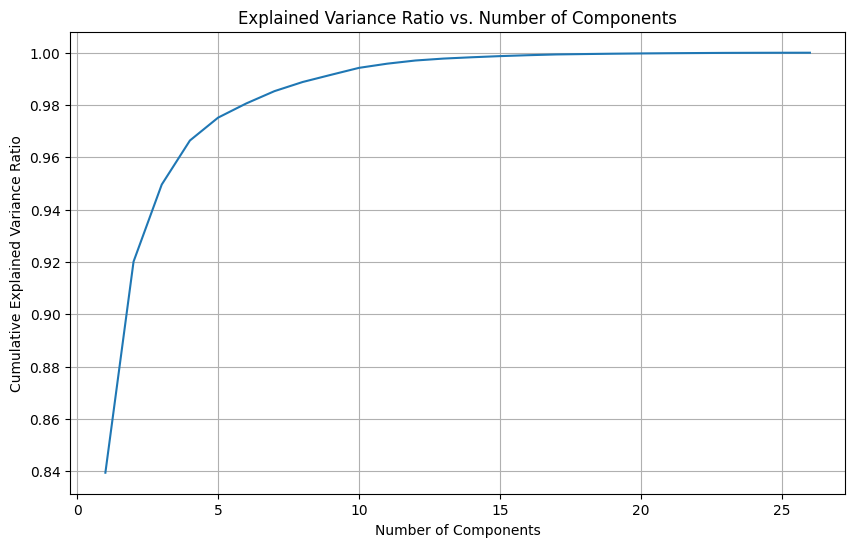

Measurement Point Importance:
           PC1       PC2       PC3       PC4       PC5
SG23  0.213455  0.003003  0.002723  0.057742  0.039084
SG17  0.213394  0.008233  0.001630  0.053953  0.026612
SG10  0.213021  0.014438  0.005670  0.040398  0.027564
SG4   0.212771  0.004183  0.012826  0.053470  0.010696
SG21  0.212509  0.003018  0.022003  0.082488  0.017138
SG11  0.212504  0.038266  0.019063  0.101611  0.070178
SG2   0.212495  0.018858  0.026102  0.044878  0.006942
SG18  0.211932  0.059934  0.014926  0.118382  0.037774
SG1   0.211394  0.000862  0.055807  0.085505  0.035547
SG24  0.211365  0.063051  0.029108  0.134165  0.004652
SG12  0.210810  0.064291  0.039389  0.106958  0.078260
SG15  0.210705  0.028547  0.018303  0.003905  0.059608
SG6   0.209979  0.047060  0.017920  0.068371  0.184909
SG5   0.209903  0.058745  0.042840  0.082000  0.128817
SG8   0.209487  0.082504  0.008019  0.046762  0.068312
SG3   0.208904  0.052262  0.022487  0.069779  0.178981
SG14  0.207723  0.050936  0.005858 

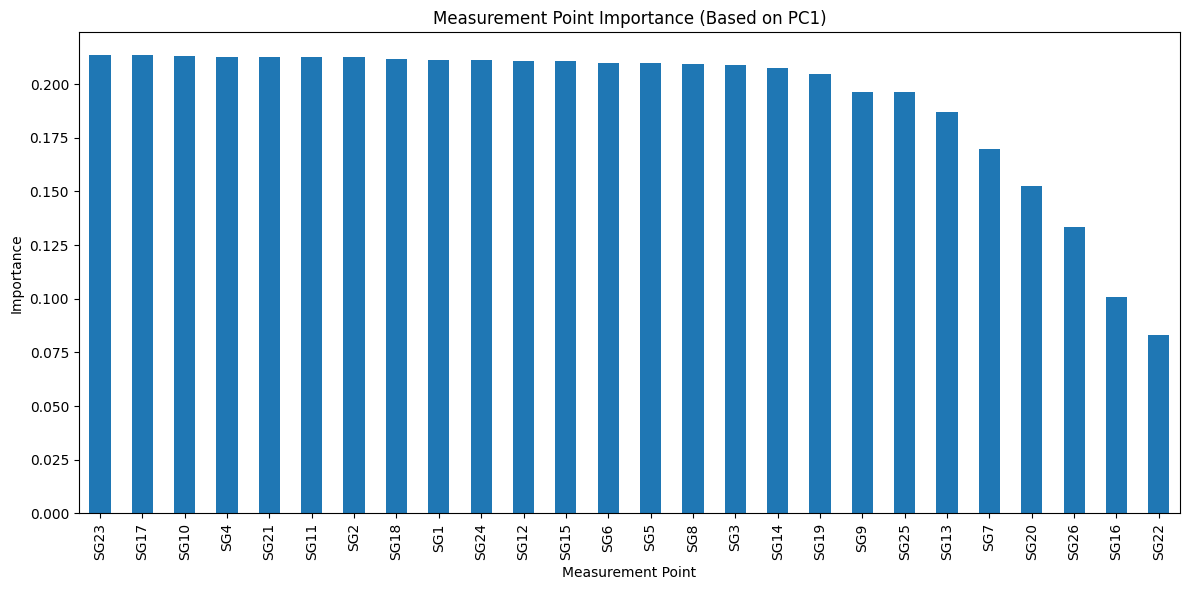

In [ ]:
# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Analyzing Strain Gauge Importance
# Get the absolute values of the first few principal components
component_importance = np.abs(pca.components_[:9])  # Adjust the number of components as needed

# Create a DataFrame to store the importance of each measurement point
sg_importance = pd.DataFrame(
    component_importance.T,
    columns=[f'PC{i+1}' for i in np.arange(component_importance.shape[0])],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Sort measurement points by their importance in the first principal component
sg_importance_sorted = sg_importance.sort_values('PC1', ascending=False)

print("Measurement Point Importance:")
print(sg_importance_sorted)

# Visualize the importance of measurement points
plt.figure(figsize=(12, 6))
sg_importance_sorted['PC1'].plot(kind='bar')
plt.title('Measurement Point Importance (Based on PC1)')
plt.xlabel('Measurement Point')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [ ]:
print("\n".join(f"{i}\t{var}" for i, var in zip(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)))


1	0.8394707505695405
2	0.9201726230136057
3	0.9496129092862954
4	0.9664534401292705
5	0.9751945914682989
6	0.9806161538472523
7	0.9853156024580089
8	0.9888092877778314
9	0.9915387624255174
10	0.9942168544860084
11	0.9958147343846024
12	0.9970249646288019
13	0.9977634726687452
14	0.998264567862053
15	0.9987006632599401
16	0.999052024956478
17	0.9993441059574025
18	0.9994897171438222
19	0.9996215065090489
20	0.9997252874189777
21	0.9998090884825246
22	0.9998774472882227
23	0.9999393502398932
24	0.9999693568681323
25	0.999990605044631
26	0.9999999999999999


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Removing Redundant Measurement Points
# Set a threshold for cumulative explained variance
threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print(f"Number of components needed to explain {threshold*100}% of variance: {n_components}")

# Get the loadings for the retained components
loadings = pd.DataFrame(
    pca.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in np.arange(n_components)],
    index=[f'SG{i+1}' for i in np.arange(X.shape[1])]
)

# Calculate the maximum absolute loading for each measurement point
max_loadings = loadings.abs().max(axis=1)

# Sort measurement points by their maximum loading
sorted_sg = max_loadings.sort_values(ascending=False)

print("\nMeasurement points sorted by importance:")
print(sorted_sg)

# Select the top N important strain gauges, where N is the number of components
important_sgs = sorted_sg.head(n_components).index.tolist()

print("\nImportant strain gauges:")
print(important_sgs)

# Calculate the cumulative importance of the selected strain gauges
selected_importance = sorted_sg.head(n_components).sum() / sorted_sg.sum()
print(f"\nCumulative importance of selected strain gauges: {selected_importance:.4f}")

Number of components needed to explain 99.0% of variance: 9

Measurement points sorted by importance:
SG22    0.575241
SG7     0.570184
SG13    0.542234
SG20    0.537669
SG16    0.504298
SG26    0.494123
SG9     0.425284
SG14    0.388870
SG15    0.341215
SG3     0.319807
SG8     0.276721
SG2     0.236439
SG1     0.224820
SG19    0.215865
SG23    0.213455
SG17    0.213394
SG10    0.213021
SG4     0.212771
SG21    0.212509
SG11    0.212504
SG18    0.211932
SG24    0.211365
SG12    0.210810
SG6     0.209979
SG5     0.209903
SG25    0.202201
dtype: float64

Important strain gauges:
['SG22', 'SG7', 'SG13', 'SG20', 'SG16', 'SG26', 'SG9', 'SG14', 'SG15']

Cumulative importance of selected strain gauges: 0.5349


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import io

# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name = next(iter(uploaded))

# Read the Excel file
excel_file = pd.ExcelFile(io.BytesIO(uploaded[file_name]))

# Read the data from the Excel file
data = pd.read_excel(excel_file, header=0, index_col=0)

# Transpose the data so that each row represents a configuration
X = data.T

# Rename columns to represent strain gauges
X.columns = [f'SG{i+1}' for i in np.arange(X.shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X = X.dropna()

combined_data = X

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
np.shape(X_scaled)

Saving 2_Smoothed_Twist2Strains_From_DIC_9cycles.xlsx to 2_Smoothed_Twist2Strains_From_DIC_9cycles.xlsx


(3140, 26)

In [ ]:
# Prepare input (X) and target (y) data
X = combined_data[important_sgs]
y = combined_data.drop(columns=important_sgs)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Create PyTorch datasets
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StrainDataset(X_train_scaled, y_train_scaled)
test_dataset = StrainDataset(X_test_scaled, y_test_scaled)

In [ ]:
print(np.shape(X))
print(np.shape(y))

(3140, 9)
(3140, 17)


Epoch [1/50], Train Loss: 0.2680, Test Loss: 0.0105
Epoch [2/50], Train Loss: 0.0084, Test Loss: 0.0081
Epoch [3/50], Train Loss: 0.0071, Test Loss: 0.0071
Epoch [4/50], Train Loss: 0.0062, Test Loss: 0.0061
Epoch [5/50], Train Loss: 0.0055, Test Loss: 0.0053
Epoch [6/50], Train Loss: 0.0049, Test Loss: 0.0047
Epoch [7/50], Train Loss: 0.0043, Test Loss: 0.0043
Epoch [8/50], Train Loss: 0.0038, Test Loss: 0.0037
Epoch [9/50], Train Loss: 0.0034, Test Loss: 0.0032
Epoch [10/50], Train Loss: 0.0031, Test Loss: 0.0029
Epoch [11/50], Train Loss: 0.0029, Test Loss: 0.0028
Epoch [12/50], Train Loss: 0.0027, Test Loss: 0.0028
Epoch [13/50], Train Loss: 0.0026, Test Loss: 0.0029
Epoch [14/50], Train Loss: 0.0026, Test Loss: 0.0025
Epoch [15/50], Train Loss: 0.0025, Test Loss: 0.0026
Epoch [16/50], Train Loss: 0.0024, Test Loss: 0.0026
Epoch [17/50], Train Loss: 0.0023, Test Loss: 0.0023
Epoch [18/50], Train Loss: 0.0022, Test Loss: 0.0023
Epoch [19/50], Train Loss: 0.0023, Test Loss: 0.0022
Ep

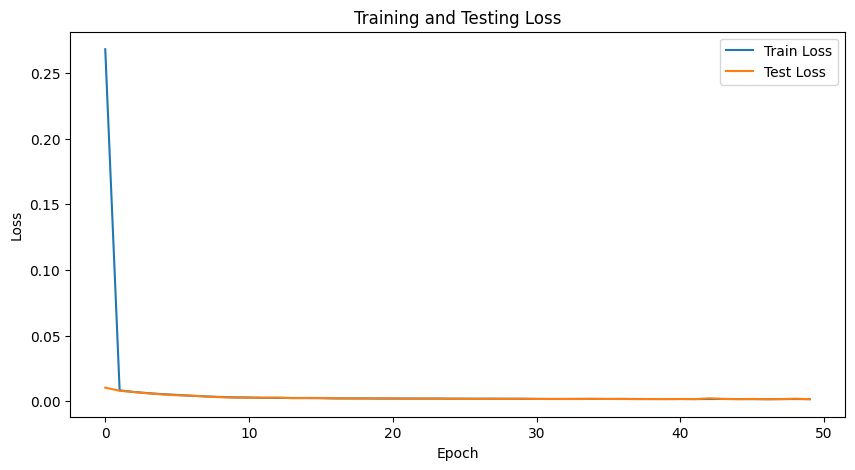

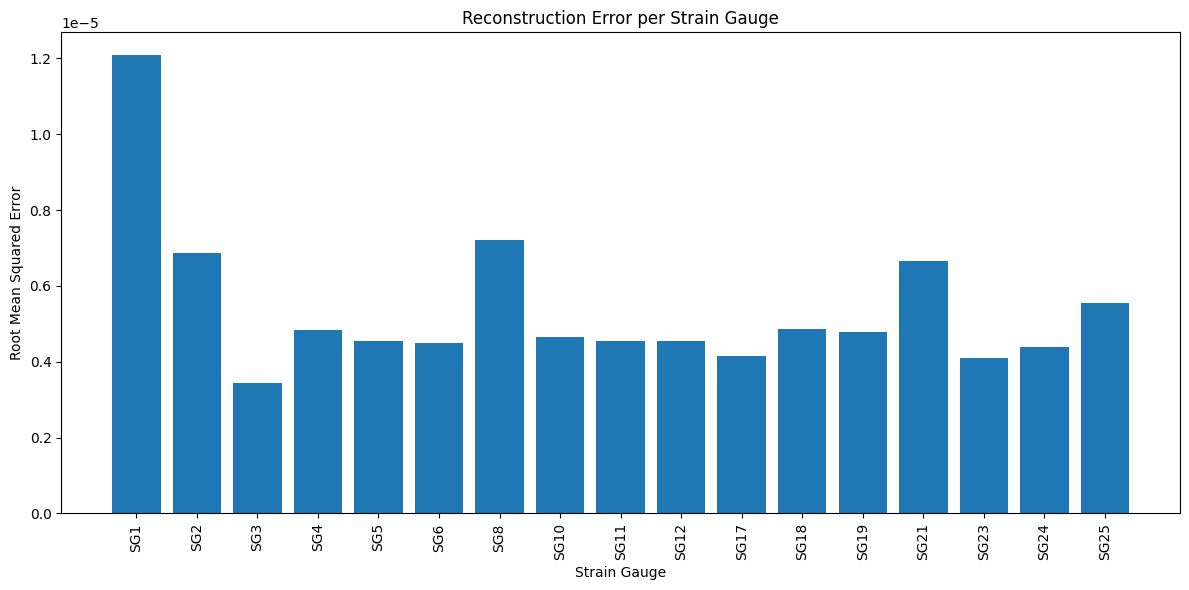

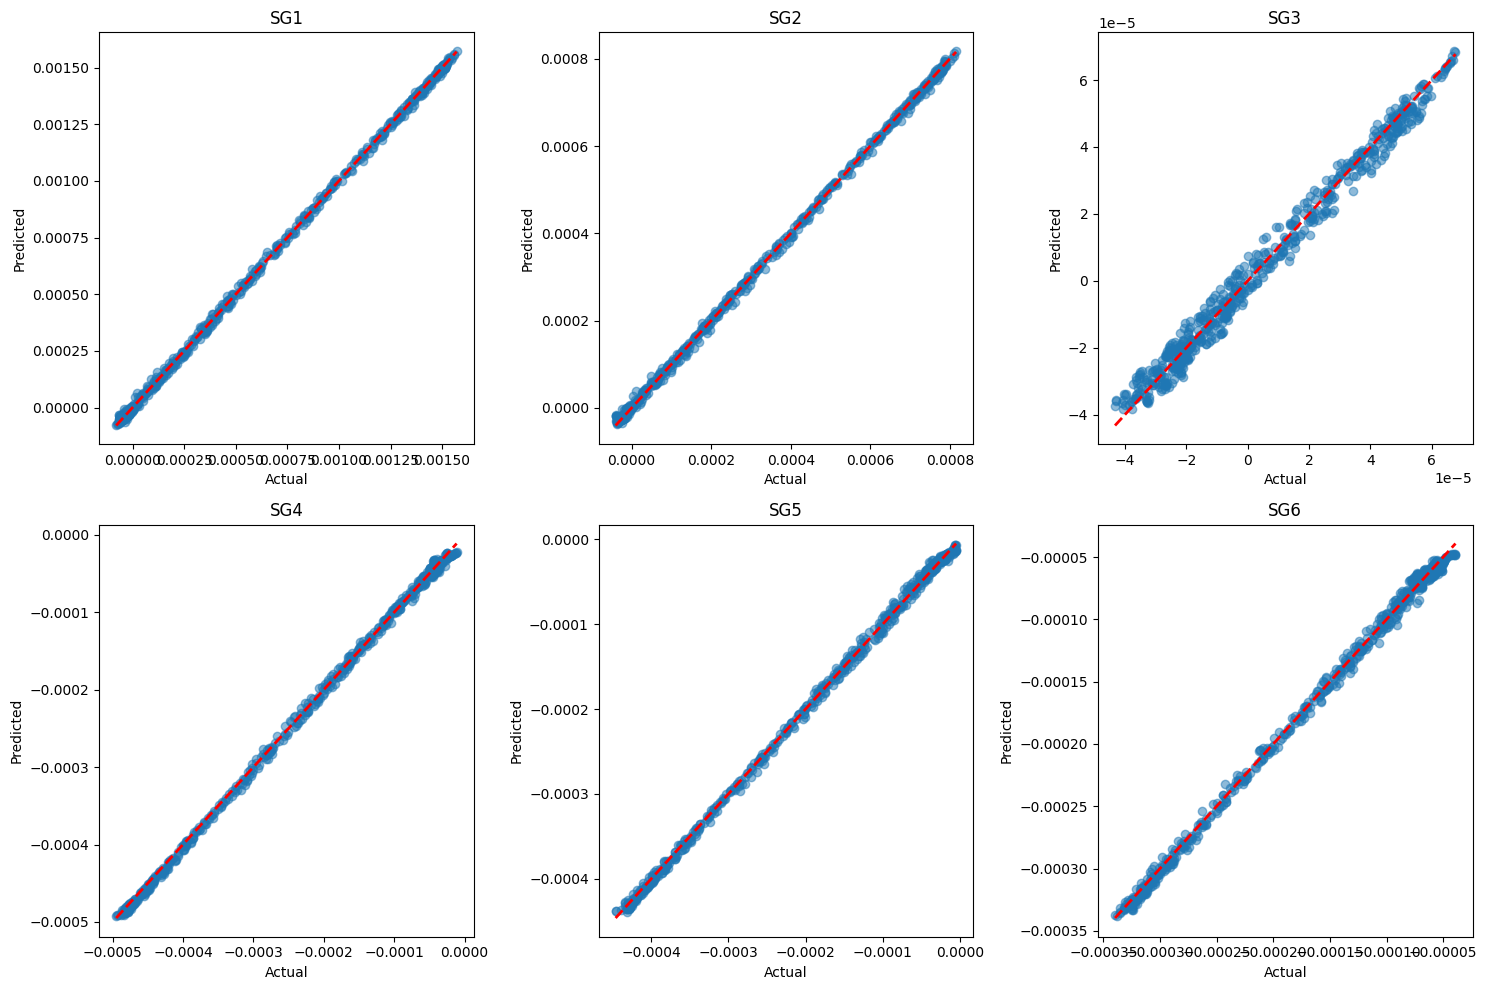

Model training and evaluation complete.


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model
class StrainFieldReconstructor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StrainFieldReconstructor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = StrainFieldReconstructor(input_size=len(important_sgs), hidden_size=64, output_size=y.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in np.arange(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# Evaluate the model on the test set
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        actuals.append(targets.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the predictions and actuals
predictions_original = scaler_y.inverse_transform(predictions)
actuals_original = scaler_y.inverse_transform(actuals)

# Calculate MSE for each strain gauge
mse_per_sg = np.mean((predictions_original - actuals_original)**2, axis=0)

rmse_per_sg = np.sqrt(np.mean((predictions_original - actuals_original)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs, rmse_per_sg)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs = [sg for sg in combined_data.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs[i]
    sg_index = combined_data.columns.get_loc(sg)
    axes[i].scatter(actuals_original[:, sg_index], predictions_original[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 [actuals_original[:, sg_index].min(), actuals_original[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


print("Model training and evaluation complete.")
torch.save(model.state_dict(), '1_Arduino_Bending_TopSurface.pth')



In [ ]:
for sg, mse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}\t{mse}")

SG1	1.2083021829312202e-05
SG2	6.863626822450897e-06
SG3	3.43517695000628e-06
SG4	4.8431211325805634e-06
SG5	4.544328930933261e-06
SG6	4.4939692998013925e-06
SG8	7.201445441751275e-06
SG10	4.648994490707992e-06
SG11	4.540752343018539e-06
SG12	4.54052178611164e-06
SG17	4.158886440563947e-06
SG18	4.852246547670802e-06
SG19	4.777725280291634e-06
SG21	6.652019692410249e-06
SG23	4.096855718671577e-06
SG24	4.379249730845913e-06
SG25	5.54795769858174e-06


In [ ]:
np.shape(predictions_original)

(628, 17)

In [ ]:
# Find SG1's index in output strain gauges
sg1_index = output_sgs.index('SG1')

# Extract and save data
predicted_sg1 = predictions_original[:, sg1_index]
actual_sg1 = actuals_original[:, sg1_index]

np.savetxt('predicted_sg1.txt', predicted_sg1, fmt='%.6f')
np.savetxt('actual_sg1.txt', actual_sg1, fmt='%.6f')

from google.colab import files
files.download('predicted_sg1.txt')
files.download('actual_sg1.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

def calculate_rmse(predictions, actuals):
    return np.sqrt(np.mean((predictions - actuals) ** 2))
rmse = calculate_rmse(predictions_original, actuals_original)
print(f"RMSE: {rmse}")


RMSE: 5.732154022553004e-06


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Print shapes of training and test data
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training output shape: {y_train_scaled.shape}")
print(f"Test output shape: {y_test_scaled.shape}")

# Calculate RMSE for each strain gauge
rmse_per_sg = np.sqrt(mean_squared_error(actuals_original, predictions_original, multioutput='raw_values'))

# Calculate overall RMSE
overall_rmse = np.sqrt(mean_squared_error(actuals_original, predictions_original))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE: {overall_rmse:.2e}")

Training data shape: (2512, 9)
Test data shape: (628, 9)
Training output shape: (2512, 17)
Test output shape: (628, 17)

RMSE for each predicted strain gauge:
SG1: 1.21e-05
SG2: 6.86e-06
SG3: 3.44e-06
SG4: 4.84e-06
SG5: 4.54e-06
SG6: 4.49e-06
SG8: 7.20e-06
SG10: 4.65e-06
SG11: 4.54e-06
SG12: 4.54e-06
SG17: 4.16e-06
SG18: 4.85e-06
SG19: 4.78e-06
SG21: 6.65e-06
SG23: 4.10e-06
SG24: 4.38e-06
SG25: 5.55e-06

Overall RMSE: 5.73e-06


In [ ]:
overall_min_test = X_test.min().min()
overall_max_test = X_test.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_test:.6f} to {overall_max_test:.6f}")



Overall range across all strain gauges in the test set: -0.000348 to 0.001410


In [ ]:
range = overall_max_test - overall_min_test
rmse_percentage = (overall_rmse / range) * 100
print(f"\nRMSE as percentage of overall test range: {rmse_percentage:.2f}%")



RMSE as percentage of overall test range: 0.33%


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores = []
for i in np.arange(predictions_original.shape[1]):
    r2 = r2_score(actuals_original[:, i], predictions_original[:, i])
    r2_scores.append(r2)

# Calculate the median and range of R2 scores
median_r2 = np.median(r2_scores)
range_r2 = (min(r2_scores), max(r2_scores))

print(f"Median R2 score: {median_r2:.4f}")
print(f"Range of R2 scores: ({range_r2[0]:.4f}, {range_r2[1]:.4f})")


Median R2 score: 0.9991
Range of R2 scores: (0.9872, 0.9998)


In [ ]:
import pandas as pd

# Assuming these variables are already calculated
data = {
    "Metric": [
        "Training data shape",
        "Test data shape",
        "Overall RMSE",
        "Overall range across all strain gauges in the test set",
        "RMSE as percentage of overall test range",
        "Median R2 score",
        "Range of R2 scores"
    ],
    "Value": [
        f"{X_train.shape}",
        f"{X_test.shape}",
        f"{overall_rmse:.6f}",
        f"{overall_min_test:.6f} to {overall_max_test:.6f}",
        f"{rmse_percentage:.2f}%",
        f"{median_r2:.2f}",
        f"({range_r2[0]:.2f}, {range_r2[1]:.2f})"
    ]
}

df = pd.DataFrame(data)

# Print the DataFrame in a tab-separated format
print(df.to_csv(sep='\t', index=False))


Metric	Value
Training data shape	(2512, 9)
Test data shape	(628, 9)
Overall RMSE	0.000006
Overall range across all strain gauges in the test set	-0.000348 to 0.001410
RMSE as percentage of overall test range	0.33%
Median R2 score	1.00
Range of R2 scores	(0.99, 1.00)



In [ ]:
# Upload the file
uploaded = files.upload()

# Get the filename of the uploaded file
file_name2 = next(iter(uploaded))

# Read the Excel file calculated_pca_sg_strains_validation.xlsx
data2 = pd.read_excel(io.BytesIO(uploaded[file_name2]), header=0, index_col=0)



Saving 3_PCA_sg_strains_plus_nonPCA_DIC_strains_2cycles.xlsx to 3_PCA_sg_strains_plus_nonPCA_DIC_strains_2cycles.xlsx


In [ ]:
# Transpose the data so that each row represents a configuration
X_validation = data2.T

# Rename columns to represent strain gauges
X_validation_columns = [f'SG{i+1}' for i in np.arange(X_validation .shape[1])]

# Convert data to numeric, replacing any non-numeric values with NaN
X_validation  = X_validation .apply(pd.to_numeric, errors='coerce')

# Remove any rows with NaN values
X_validation  = X_validation .dropna()

combined_data_val = X_validation.copy()

In [ ]:
print(X_validation.columns)
print(np.shape(X_validation))

Index(['SG22', 'SG7', 'SG13', 'SG20', 'SG16', 'SG26', 'SG9', 'SG14', 'SG15',
       'SG1', 'SG2', 'SG3', 'SG4', 'SG5', 'SG6', 'SG8', 'SG10', 'SG11', 'SG12',
       'SG17', 'SG18', 'SG19', 'SG21', 'SG23', 'SG24', 'SG25'],
      dtype='object', name='StrainGauge')
(388, 26)


In [ ]:

X_validation  = combined_data_val[important_sgs]
y_validation  = combined_data_val.drop(columns=important_sgs)
print(np.shape(X_validation))
print(np.shape(y_validation))

(388, 9)
(388, 17)


In [ ]:
X_validation_scaled = scaler_X.transform(X_validation)

In [ ]:
y_validation_scaled = scaler_y.transform(y_validation)

In [ ]:
validation_dataset = StrainDataset(X_validation_scaled, y_validation_scaled)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
# Evaluate the model on the validation set
model.eval()
predictions_val = []
actuals_val = []
with torch.no_grad():
    for inputs, targets in validation_loader:
        outputs = model(inputs)
        predictions_val.append(outputs.numpy())
        actuals_val.append(targets.numpy())

In [ ]:
predictions_val = np.concatenate(predictions_val)
actuals_val = np.concatenate(actuals_val)

# Inverse transform the predictions and actuals
predictions_original_val = scaler_y.inverse_transform(predictions_val)
actuals_original_val = scaler_y.inverse_transform(actuals_val)

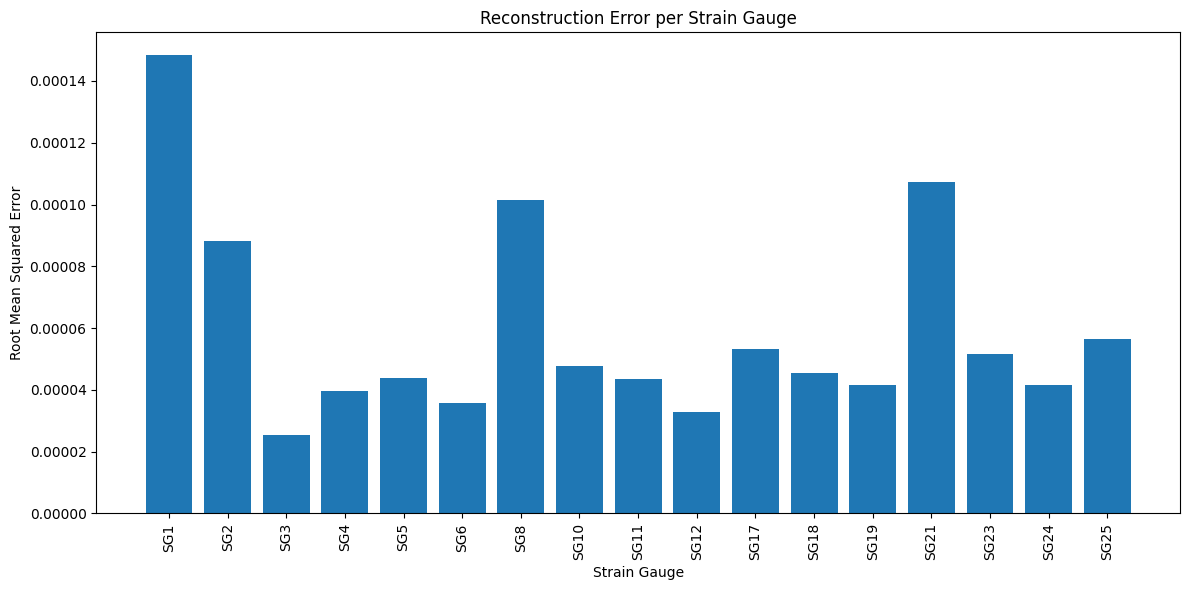

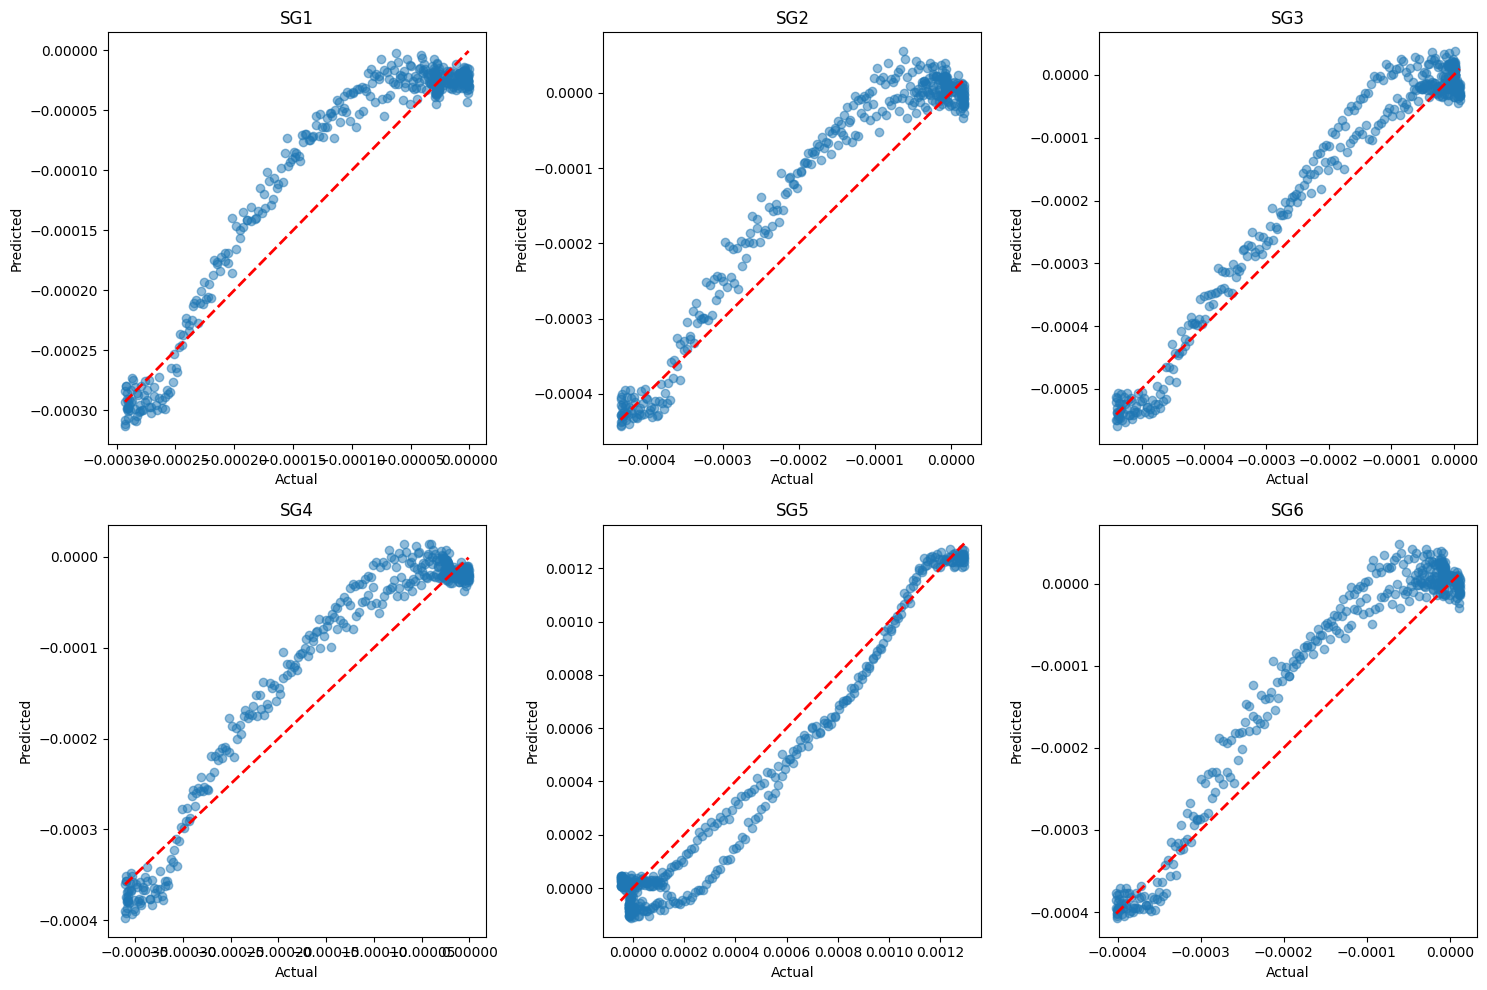

In [ ]:
# Calculate MSE for each strain gauge
mse_per_sg_val = np.mean((predictions_original_val - actuals_original_val)**2, axis=0)

rmse_per_sg_val = np.sqrt(np.mean((predictions_original_val - actuals_original_val)**2, axis=0))

# Create a list of strain gauge names for the MSE values
output_sgs_val = [f'SG{i+1}' for i in np.arange(len(combined_data_val.columns)) if f'SG{i+1}' not in important_sgs]

# Plot MSE for each predicted strain gauge
plt.figure(figsize=(12, 6))
plt.bar(output_sgs_val, rmse_per_sg_val)
plt.xlabel('Strain Gauge')
plt.ylabel('Root Mean Squared Error')
plt.title('Reconstruction Error per Strain Gauge')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Visualize actual vs predicted for a few strain gauges, excluding important ones
output_sgs_val = [sg for sg in combined_data_val.columns if sg not in important_sgs]

num_plots = min(6, len(output_sgs_val))
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i in np.arange(num_plots):
    sg = output_sgs_val[i]
    sg_index = combined_data_val.columns.get_loc(sg)
    axes[i].scatter(actuals_original_val[:, sg_index], predictions_original_val[:, sg_index], alpha=0.5)
    axes[i].plot([actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 [actuals_original_val[:, sg_index].min(), actuals_original_val[:, sg_index].max()],
                 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(sg)

# Remove any unused subplots
for i in np.arange(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
for sg, mse in zip(output_sgs_val, rmse_per_sg_val):
    print(f"{sg}\t{mse}")

SG1	0.0001483246887801215
SG2	8.835561311570928e-05
SG3	2.5416882635909133e-05
SG4	3.978539098170586e-05
SG5	4.3871375964954495e-05
SG6	3.5825119994115084e-05
SG8	0.00010138257493963465
SG10	4.7731067752465606e-05
SG11	4.36704904132057e-05
SG12	3.2934349292190745e-05
SG17	5.339282870409079e-05
SG18	4.557626380119473e-05
SG19	4.1592909838072956e-05
SG21	0.00010713863593991846
SG23	5.169593350728974e-05
SG24	4.1661336581455544e-05
SG25	5.6470438721589744e-05


In [ ]:
np.shape(predictions_original_val)

(388, 17)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores_val = []
for i in np.arange(predictions_original_val.shape[1]):
    r2_val = r2_score(actuals_original_val[:, i], predictions_original_val[:, i])
    r2_scores_val.append(r2_val)
    print(f"R2 score for strain gauge {i+1}: {r2_val:.4f}")

# Calculate the median and range of R2 scores
median_r2_val = np.median(r2_scores_val)
range_r2_val = (min(r2_scores_val), max(r2_scores_val))

print(f"\nMedian R2 score: {median_r2_val:.4f}")
print(f"Range of R2 scores: ({range_r2_val[0]:.4f}, {range_r2_val[1]:.4f})")


R2 score for strain gauge 1: 0.9391
R2 score for strain gauge 2: 0.9173
R2 score for strain gauge 3: 0.1530
R2 score for strain gauge 4: 0.9466
R2 score for strain gauge 5: 0.9125
R2 score for strain gauge 6: 0.8832
R2 score for strain gauge 7: 0.9525
R2 score for strain gauge 8: 0.9163
R2 score for strain gauge 9: 0.9268
R2 score for strain gauge 10: 0.8925
R2 score for strain gauge 11: 0.8846
R2 score for strain gauge 12: 0.9451
R2 score for strain gauge 13: 0.8904
R2 score for strain gauge 14: 0.9484
R2 score for strain gauge 15: 0.8717
R2 score for strain gauge 16: 0.9370
R2 score for strain gauge 17: 0.8408

Median R2 score: 0.9163
Range of R2 scores: (0.1530, 0.9525)


In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Calculate R2 scores for each unknown strain gauge
r2_scores_val = []
for i in np.arange(predictions_original_val.shape[1]):
    r2_val = r2_score(actuals_original_val[:, i], predictions_original_val[:, i])
    r2_scores_val.append(r2_val)
    print(f"R2 score for strain gauge {i+1}: {r2_val:.4f}")

# Exclude SG3 (assumed to be index 2)
exclude_index = 2  # Change this if SG3 is a different column
r2_scores_excluding_SG3 = [score for idx, score in enumerate(r2_scores_val) if idx != exclude_index]

# Calculate the median and range of R2 scores excluding SG3
median_r2_val_excl_SG3 = np.median(r2_scores_excluding_SG3)
range_r2_val_excl_SG3 = (min(r2_scores_excluding_SG3), max(r2_scores_excluding_SG3))

print(f"\nMedian R2 score (excluding SG3): {median_r2_val_excl_SG3:.4f}")
print(f"Range of R2 scores (excluding SG3): ({range_r2_val_excl_SG3[0]:.4f}, {range_r2_val_excl_SG3[1]:.4f})")


R2 score for strain gauge 1: 0.9391
R2 score for strain gauge 2: 0.9173
R2 score for strain gauge 3: 0.1530
R2 score for strain gauge 4: 0.9466
R2 score for strain gauge 5: 0.9125
R2 score for strain gauge 6: 0.8832
R2 score for strain gauge 7: 0.9525
R2 score for strain gauge 8: 0.9163
R2 score for strain gauge 9: 0.9268
R2 score for strain gauge 10: 0.8925
R2 score for strain gauge 11: 0.8846
R2 score for strain gauge 12: 0.9451
R2 score for strain gauge 13: 0.8904
R2 score for strain gauge 14: 0.9484
R2 score for strain gauge 15: 0.8717
R2 score for strain gauge 16: 0.9370
R2 score for strain gauge 17: 0.8408

Median R2 score (excluding SG3): 0.9168
Range of R2 scores (excluding SG3): (0.8408, 0.9525)


In [ ]:
# Calculate overall RMSE
overall_rmse_val = np.sqrt(mean_squared_error(actuals_original_val, predictions_original_val))

# Create a list of strain gauge names, excluding the important ones
output_sgs = [f'SG{i+1}' for i in np.arange(len(combined_data.columns)) if f'SG{i+1}' not in important_sgs]


# Print RMSE for each predicted strain gauge
print("\nRMSE for each predicted strain gauge:")
for sg, rmse in zip(output_sgs, rmse_per_sg_val):
    print(f"{sg}: {rmse:.2e}")

print(f"\nOverall RMSE Val: {overall_rmse_val:.2e}")


RMSE for each predicted strain gauge:
SG1: 1.48e-04
SG2: 8.84e-05
SG3: 2.54e-05
SG4: 3.98e-05
SG5: 4.39e-05
SG6: 3.58e-05
SG8: 1.01e-04
SG10: 4.77e-05
SG11: 4.37e-05
SG12: 3.29e-05
SG17: 5.34e-05
SG18: 4.56e-05
SG19: 4.16e-05
SG21: 1.07e-04
SG23: 5.17e-05
SG24: 4.17e-05
SG25: 5.65e-05

Overall RMSE Val: 6.71e-05


In [ ]:
overall_min_val = X_validation.min().min()
overall_max_val = X_validation.max().max()
print(f"\nOverall range across all strain gauges in the test set: {overall_min_val:.6f} to {overall_max_val:.6f}")

range_val = overall_max_val - overall_min_val
rmse_percentage_val = (overall_rmse_val / range_val) * 100
print(f"\nRMSE as percentage of overall validation range: {rmse_percentage_val:.2f}%")


Overall range across all strain gauges in the test set: -0.000373 to 0.001410

RMSE as percentage of overall validation range: 3.76%
